## Statistical test to see if there is a difference in score between established/non-established

_All groups: established, non-established, governmental/institutional, other, not\_clear_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, ttest_ind
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from util import gather_dataset, z_score_per_worker, z_score_per_task

In [67]:
def load_data(
    publisher_annotations_path: str, claimant_annotations_path: str
) -> pd.DataFrame:
    """Load the annotations annotated publishers, their category, and their average score into a dataframe"""
    publisher_df = pd.read_csv(publisher_annotations_path)
    claimant_df = gather_dataset(claimant_annotations_path)

    # perform an inner join on the publisher and claimant dataframes on the publisher name
    joint_df = pd.merge(publisher_df, claimant_df, on='publisher')

    del publisher_df, claimant_df # unload dfs from memory to prevent crashes

    # optionally z-score the scores before performing the statistical tests
    joint_df = z_score_per_task(joint_df)
    joint_df = z_score_per_worker(joint_df)

    # return joint_df

    # group all the claimants by the publisher and calculate the average score for each publisher
    # make sure to keep the mainstream or alternative category
    grouped_df = joint_df.groupby(['publisher', 'category'], as_index=False).agg(
        {'score': 'mean', 'z_score_worker': 'mean', 'z_score_task': 'mean'}
    )

    return grouped_df

stats_df = load_data('./annotations/publisher_annotations.csv', './data/claimant_data_processed/')
stats_df.head()

/home/bbjoverbeek/master_thesis/util.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(
/home/bbjoverbeek/master_thesis/util.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(


,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417664,1.774801e-17,-0.070536
1,@berkeleywellness,other,2.507514,1.177608e-17,-0.075999
2,ABC News,established,4.002075,-4.906614e-18,0.045651
3,AGE OF AUTISM,not established,1.969742,1.150113e-17,-0.035269
4,Activist Post,not established,2.332694,3.302175e-17,0.247459


<Axes: title={'center': 'Distribution of Publishers per Category'}, xlabel='category'>

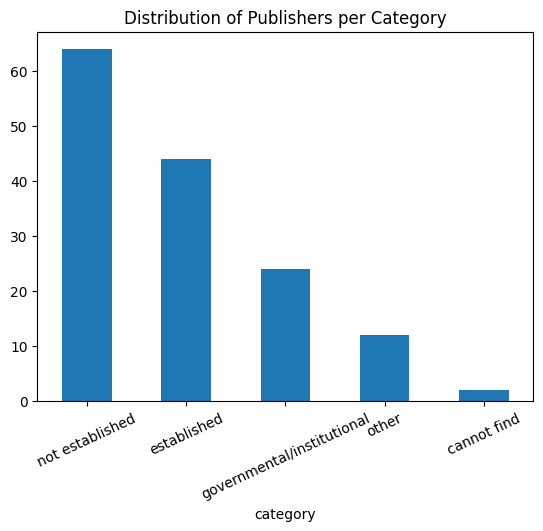

In [68]:
stats_df.value_counts('category').plot(kind='bar', title='Distribution of Publishers per Category', rot=25)

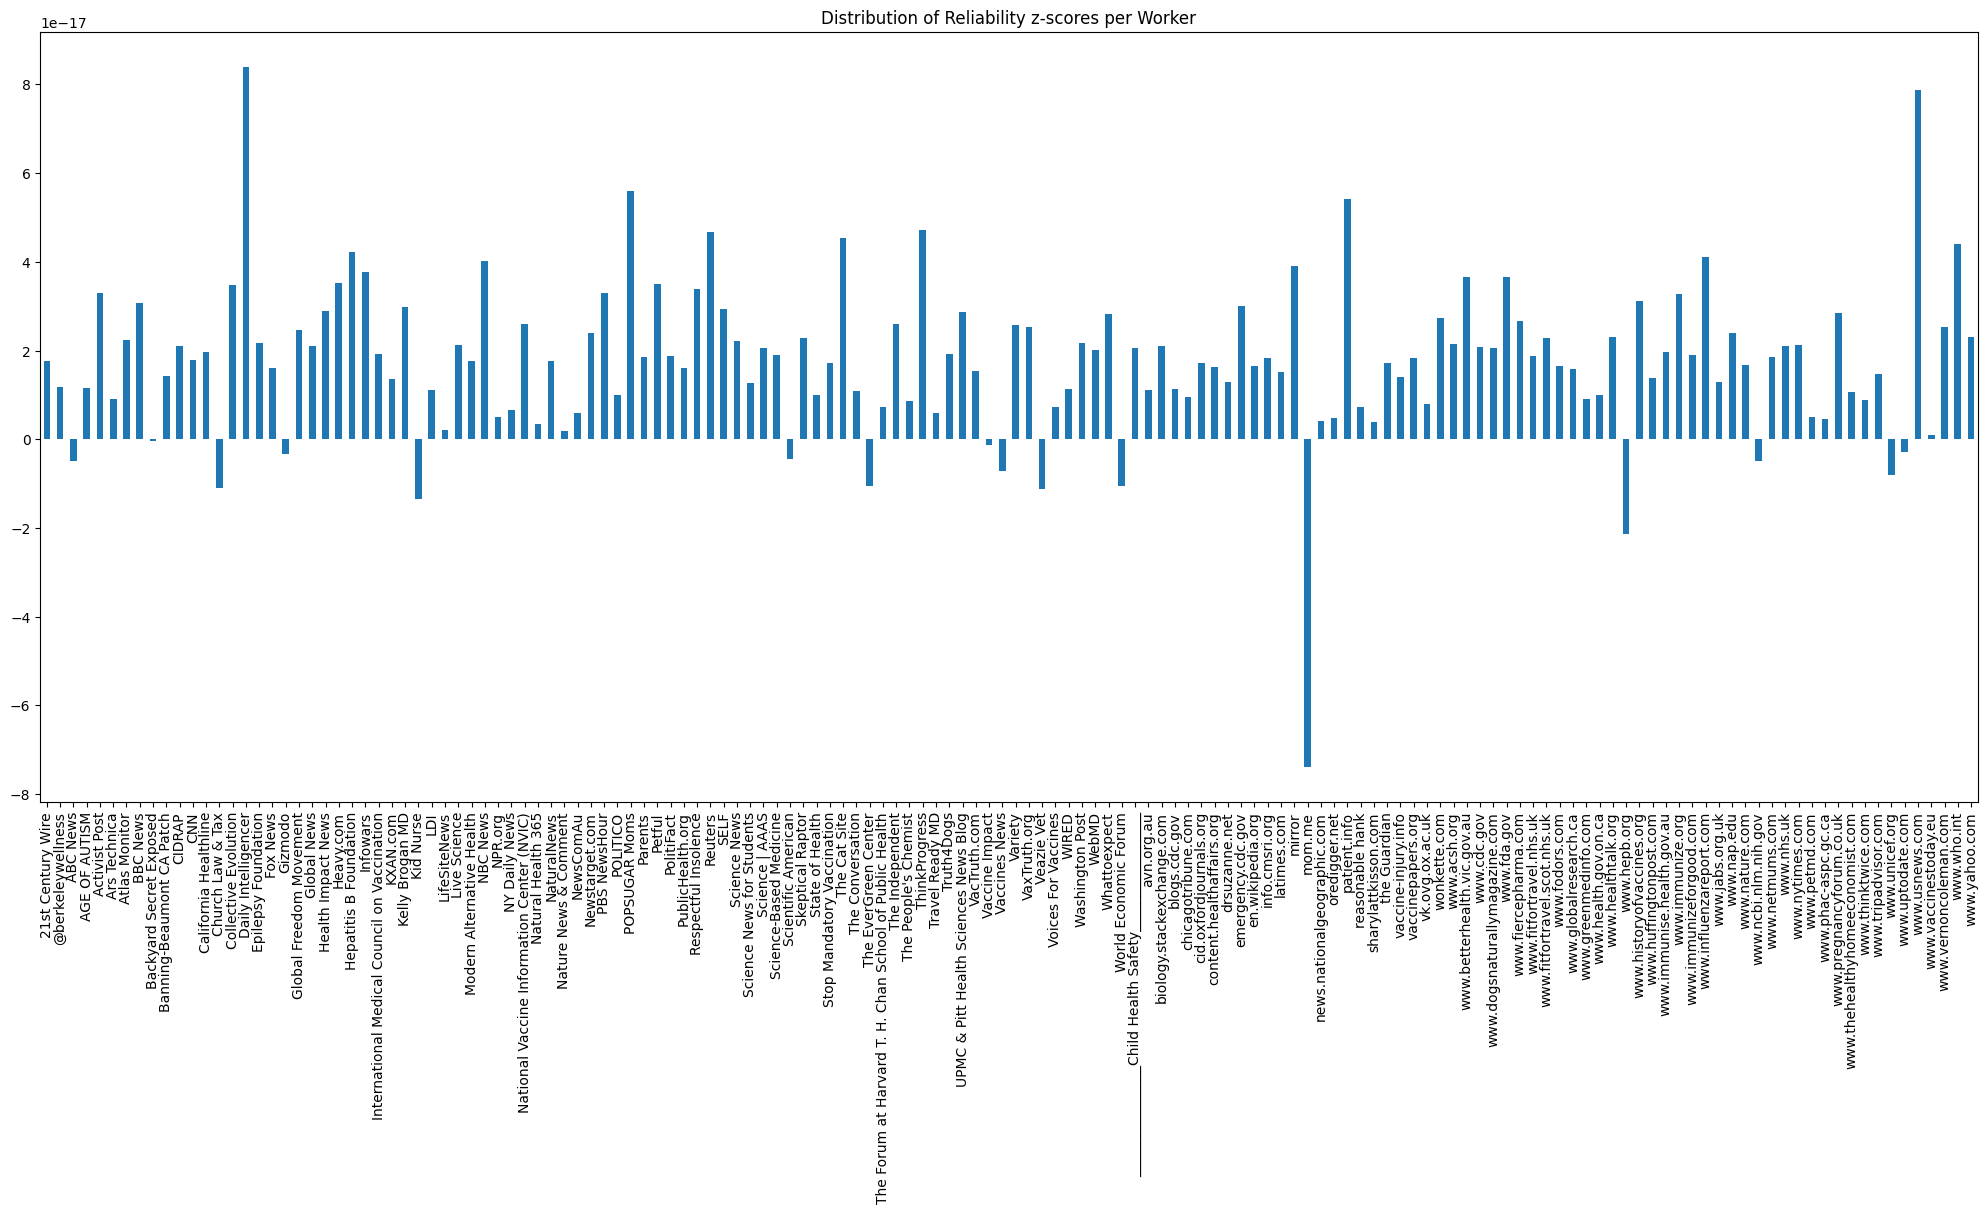

In [69]:
plot = stats_df['z_score_worker'].plot(kind='bar', title='Distribution of Reliability z-scores per Worker', figsize=(25,10))
plot.set_xticklabels(stats_df['publisher'])
plt.show()

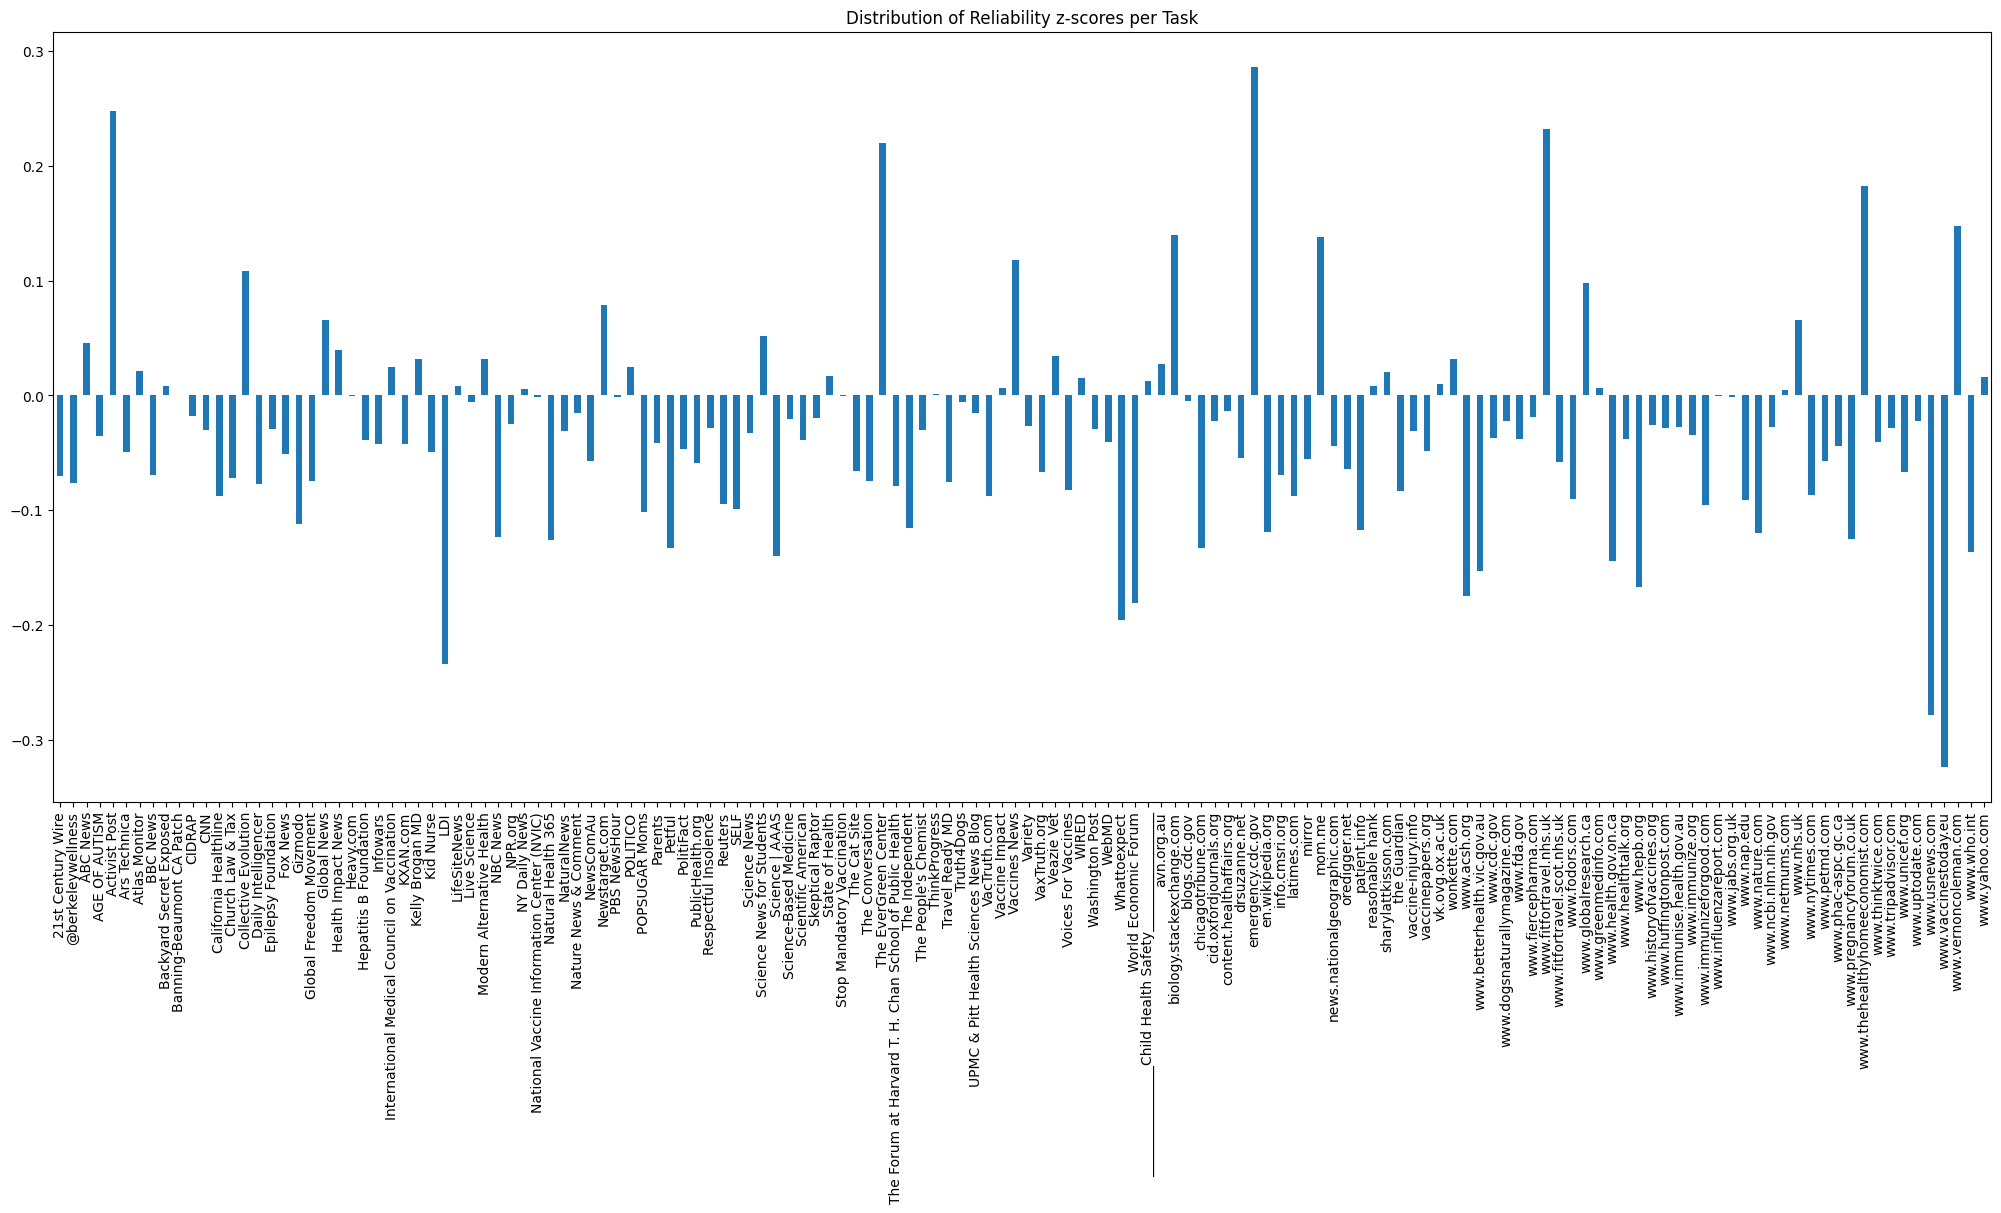

In [70]:
plot = stats_df['z_score_task'].plot(kind='bar', title='Distribution of Reliability z-scores per Task', figsize=(25,10))
plot.set_xticklabels(stats_df['publisher'])
plt.show()

In [84]:
# because the worker z-score average per publisher is much smaller, find a factor to be able to visualize their polarities

# factor = abs(stats_df['z_score_task'].mean()/stats_df['z_score_worker'].mean())
# print(f'multiplying worker z-score with {factor}')
# stats_df['z_score_worker_multiplied'] = stats_df['z_score_worker'].apply(lambda score: score * factor)

# stats_df.plot(x='publisher', y=['z_score_worker_multiplied', 'z_score_task'], kind='bar', figsize=(35, 10), title='Comparison of the Reliability z-scores per Task and per Worker (multiplied)')

### Established vs not-established

In [72]:
from typing import Literal
score_column: Literal['score', 'z_score_worker', 'z_score_task'] = 'z_score_worker'

NormaltestResult(statistic=28.935276774451495, pvalue=5.209361334658057e-07)


[]

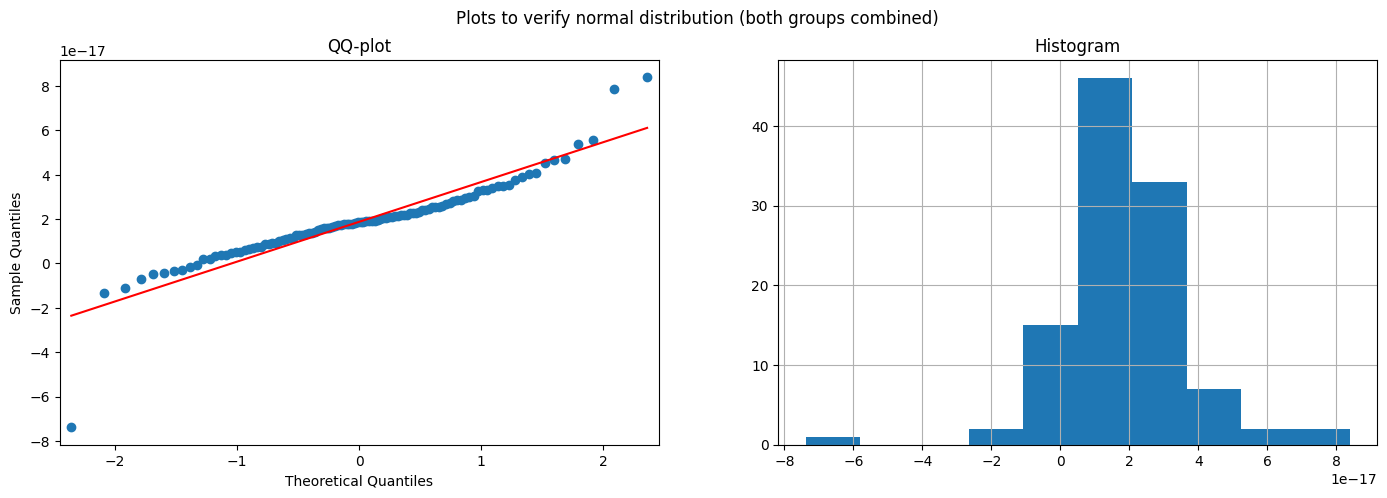

In [73]:
# filter df on only established and not established sources
df_filtered2 = stats_df[
    (stats_df['category'] == 'established') | (stats_df['category'] == 'not established')
]

# test for normal distribution
print(normaltest(df_filtered2[score_column]))

fig, ax = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle('Plots to verify normal distribution (both groups combined)')

qq_plot = sm.qqplot(df_filtered2[score_column], line='s', ax=ax[0]) 
ax[0].set_title('QQ-plot')

hist_plot = df_filtered2[score_column].hist(ax=ax[1])
ax[1].set_title('Histogram')

plt.plot()

[]

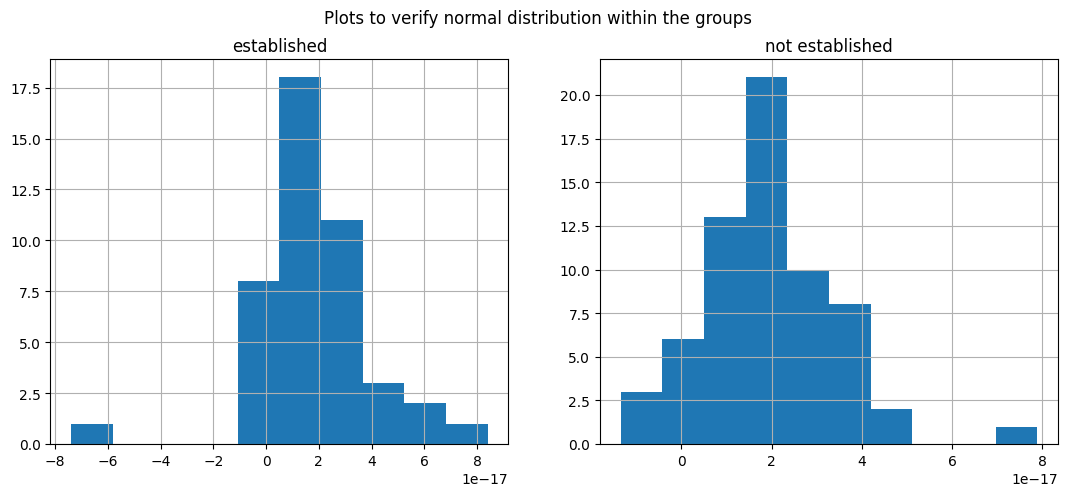

In [74]:
# distribution within each group
fig, ax = plt.subplots(1, 2, figsize=(13,5))
fig.suptitle('Plots to verify normal distribution within the groups')

df_filtered2[df_filtered2['category'] == 'established'][score_column].hist(ax=ax[0])
ax[0].set_title('established')

df_filtered2[df_filtered2['category'] == 'not established'][score_column].hist(ax=ax[1])
ax[1].set_title('not established')

plt.plot()

<Axes: title={'center': 'z_score_worker'}, xlabel='category'>

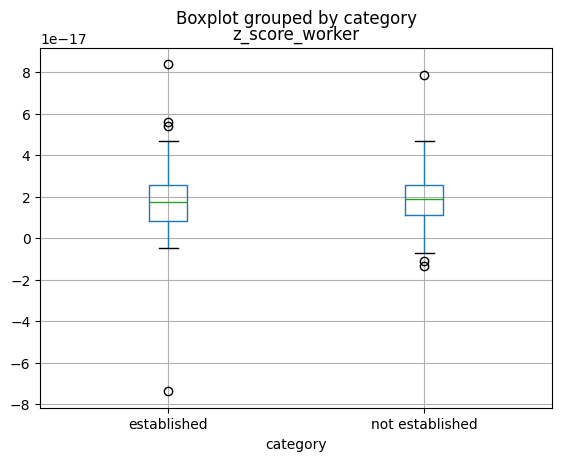

In [75]:
# create boxplot per category
df_filtered2.boxplot(column=score_column, by='category')

In [76]:
# convert the category column to a binary column
df_filtered2.loc[:, 'category'] = df_filtered2['category'].map(
    {'established': 0, 'not established': 1, 0:0, 1:1} # last two are for the case when the column is already binary
)

result = ttest_ind(
    df_filtered2[score_column].to_numpy(), df_filtered2['category'].to_numpy().astype(int)
)

print(
    f't-statistic: {result.statistic}\np-value: {result.pvalue}\ndegrees of freedom: {result.df}'
)

t-statistic: -12.475430398842503
p-value: 3.33977541741854e-27
degrees of freedom: 214.0


### Established / not established / governmental-institutional / other

NormaltestResult(statistic=30.107906743323273, pvalue=2.8983519411525883e-07)


[]

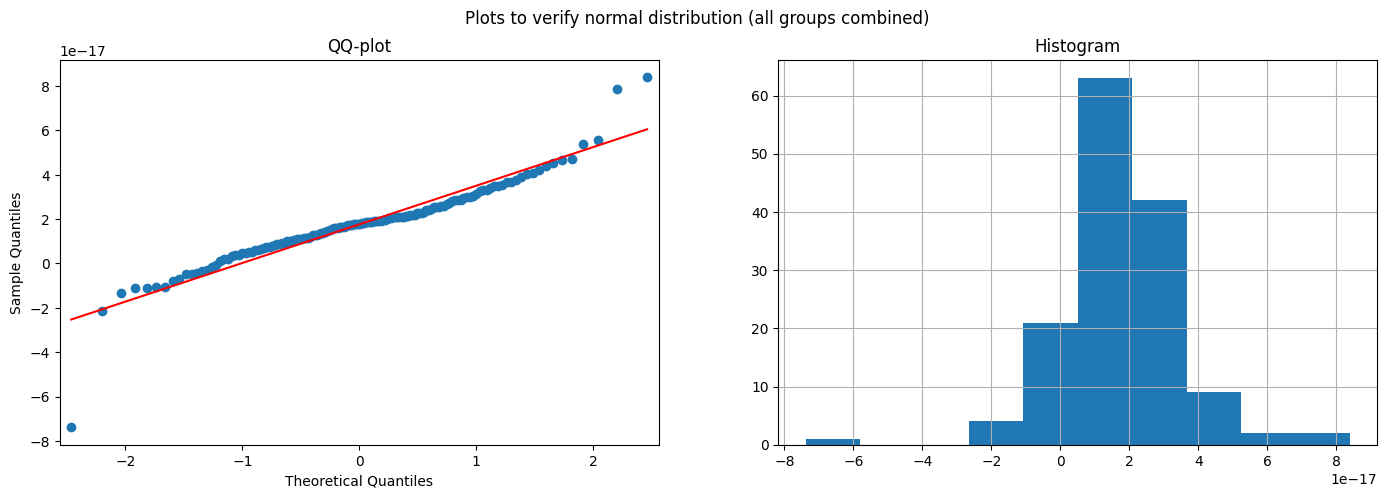

In [77]:
# filter df to remove `cannot find` items
df_filtered4 = stats_df[
    (stats_df['category'] != 'cannot find')
]

# print(f'The resulting categories are: {df_filtered4["category"].unique()}')

# test for normal distribution
print(normaltest(df_filtered4[score_column]))

fig, ax = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle('Plots to verify normal distribution (all groups combined)')
# ax[0].plot(sm.qqplot(df_filtered4['score'], line='s'))

qq_plot = sm.qqplot(df_filtered4[score_column], line='s', ax=ax[0]) 
ax[0].set_title('QQ-plot')

hist_plot = df_filtered4[score_column].hist(ax=ax[1])
ax[1].set_title('Histogram')

plt.plot()

Text(0.5, 1.0, 'other')

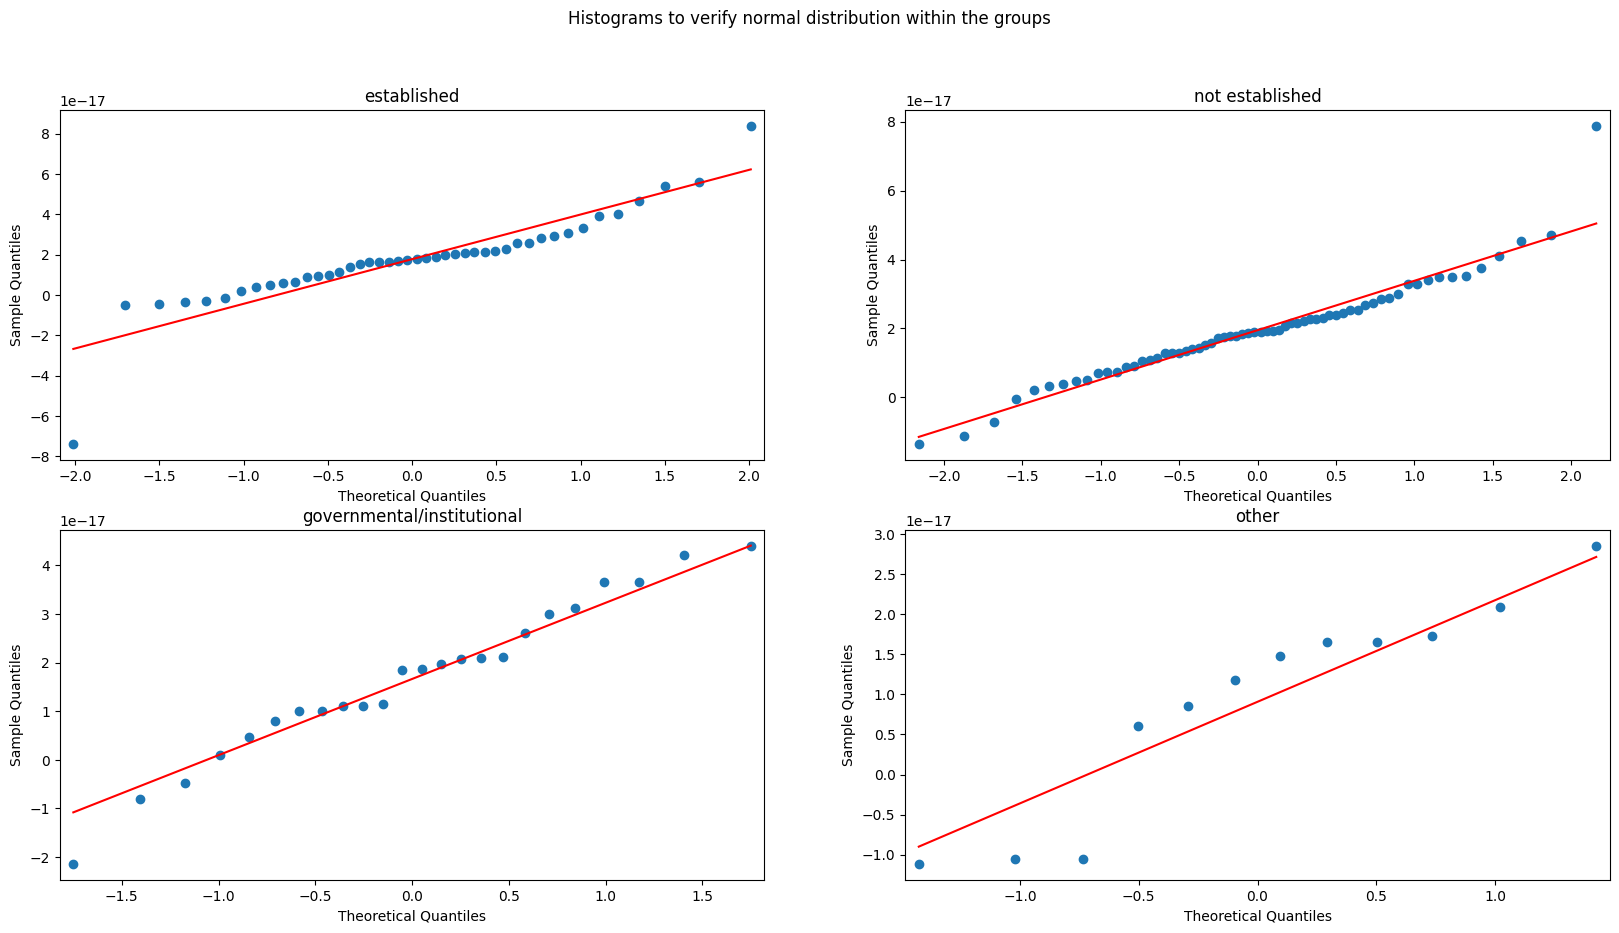

In [78]:
from typing import Literal

# distribution within each group
fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('Histograms to verify normal distribution within the groups')

linetype: Literal['s','45'] = 's'

sm.qqplot(df_filtered4[df_filtered4['category'] == 'established'][score_column], line=linetype, ax=ax[0][0]) 
ax[0][0].set_title('established')

sm.qqplot(df_filtered4[df_filtered4['category'] == 'not established'][score_column], line=linetype, ax=ax[0][1]) 
ax[0][1].set_title('not established')

sm.qqplot(df_filtered4[df_filtered4['category'] == 'governmental/institutional'][score_column], line=linetype, ax=ax[1][0]) 
ax[1][0].set_title('governmental/institutional')

sm.qqplot(df_filtered4[df_filtered4['category'] == 'other'][score_column], line=linetype, ax=ax[1][1]) 
ax[1][1].set_title('other')


Text(0.5, 1.0, 'other')

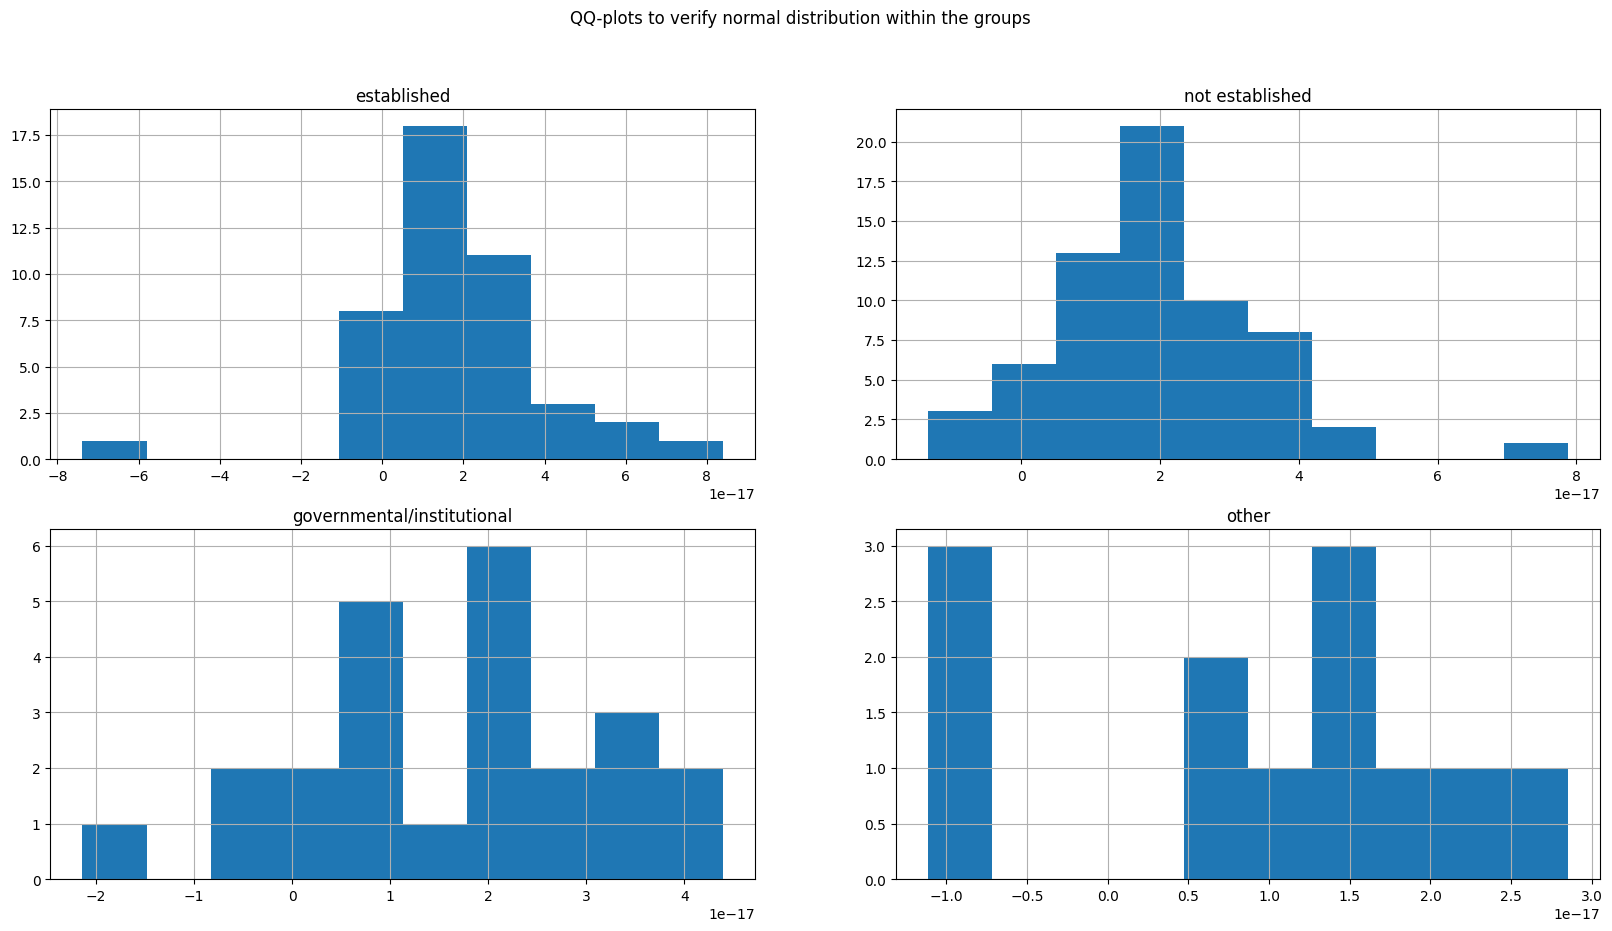

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('QQ-plots to verify normal distribution within the groups')

df_filtered4[df_filtered4['category'] == 'established'][score_column].hist(ax=ax[0][0])
ax[0][0].set_title('established')

df_filtered4[df_filtered4['category'] == 'not established'][score_column].hist(ax=ax[0][1])
ax[0][1].set_title('not established')

df_filtered4[df_filtered4['category'] == 'governmental/institutional'][score_column].hist(ax=ax[1][0])
ax[1][0].set_title('governmental/institutional')

df_filtered4[df_filtered4['category'] == 'other'][score_column].hist(ax=ax[1][1])
ax[1][1].set_title('other')


<Axes: title={'center': 'z_score_worker'}, xlabel='category'>

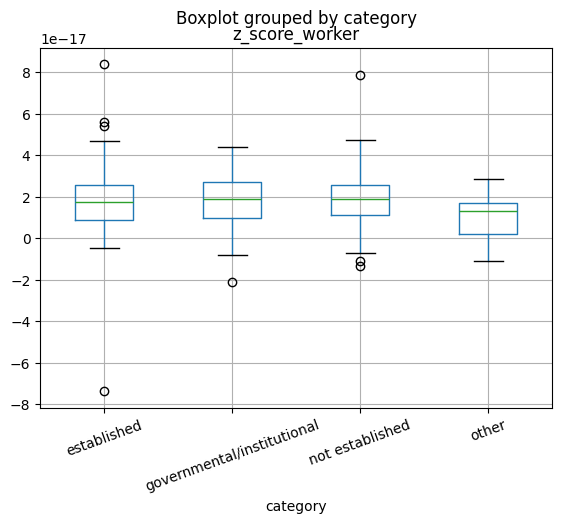

In [80]:
# create boxplot per category
df_filtered4.boxplot(column=score_column, by='category', rot=20)

In [81]:
model = ols(f'{score_column} ~ C(category)', data=df_filtered4).fit()

print(model.summary())

sm.stats.anova_lm(model, typ=2)

                            OLS Regression Results                            
Dep. Variable:         z_score_worker   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.238
Date:                Thu, 20 Jun 2024   Prob (F-statistic):              0.298
Time:                        16:59:11   Log-Likelihood:                 5354.4
No. Observations:                 144   AIC:                        -1.070e+04
Df Residuals:                     140   BIC:                        -1.069e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

,sum_sq,df,F,PR(>F)
C(category),1.129085e-33,3.0,1.238407,0.298179
Residual,4.254707e-32,140.0,NaN,NaN
